# Redshift

```{important}
`sqlalchemy-redshift` requires SQLAlchemy 1.x (as of version 0.8.14)
```

This tutorial will show you how to use JupySQL with [Redshift](https://aws.amazon.com/redshift/), a data warehouse service provided by AWS.

## Pre-requisites

First, let's install the required packages.

In [1]:
%pip install jupysql sqlalchemy-redshift redshift-connector 'sqlalchemy<2' --quiet

Note: you may need to restart the kernel to use updated packages.


Load JupySQL:

In [3]:
%load_ext sql

Found pyproject.toml from '/Users/eduardo/dev/jupysql'

## Connect to Redshift

Here, we create a connection and pass it to JupySQL:

In [4]:
from os import environ
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

user = environ["REDSHIFT_USERNAME"]
password = environ["REDSHIFT_PASSWORD"]
host = environ["REDSHIFT_HOST"]

url = URL.create(
    drivername="redshift+redshift_connector",
    username=user,
    password=password,
    host=host,
    port=5439,
    database="dev",
)

engine = create_engine(url)

In [5]:
%sql engine --alias redshift-sqlalchemy

## Load data

We'll load some sample data. First, we create the table:

In [8]:
%%sql
DROP TABLE taxi;

CREATE TABLE taxi  (
    VendorID                BIGINT,
    tpep_pickup_datetime    TIMESTAMP,
    tpep_dropoff_datetime   TIMESTAMP,
    passenger_count         DOUBLE PRECISION,
    trip_distance           DOUBLE PRECISION,
    RatecodeID              DOUBLE PRECISION,
    store_and_fwd_flag      VARCHAR(1),
    PULocationID            BIGINT,
    DOLocationID            BIGINT,
    payment_type            BIGINT,
    fare_amount             DOUBLE PRECISION,
    extra                   DOUBLE PRECISION,
    mta_tax                 DOUBLE PRECISION,
    tip_amount              DOUBLE PRECISION,
    tolls_amount            DOUBLE PRECISION,
    improvement_surcharge   DOUBLE PRECISION,
    total_amount            DOUBLE PRECISION,
    congestion_surcharge    DOUBLE PRECISION,
    airport_fee             DOUBLE PRECISION
);

Running query in 'redshift-sqlalchemy'

++
||
++
++

Now, we use `COPY` to copy a `.parquet` file stored in an S3 bucket:

```{admonition} Instructions to upload to S3
:class: tip, dropdown

If you don't have existing data and a role configured, here are the commands to do it:

Create bucket:

~~~sh
aws s3api create-bucket --bucket {bucket-name} --region {aws-region}
~~~

Download some sample data from [here](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Upload to the S3 bucket:

~~~sh
aws s3 cp path/to/data.parquet s3://{bucket-name}/data.parquet
~~~

Create a role that allows Redshift to  have S3 read access:

~~~sh
aws iam create-role --role-name {role-name} \
    --assume-role-policy-document '{"Version":"2012-10-17","Statement":[{"Effect":"Allow","Principal":{"Service":"redshift.amazonaws.com"},"Action":"sts:AssumeRole"}]}'
    
aws iam attach-role-policy --role-name {role-name} --policy-arn arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess
~~~

Then, go to the Redshift console and attach the role you created to your Redshift cluster.
```


In [2]:
%%sql
COPY taxi
FROM 's3:///some-bucket/yellow_tripdata_2023-01.parquet'
IAM_ROLE 'arn:aws:iam::XYZ:role/some-role'
FORMAT AS PARQUET;

## Query

In [6]:
%%sql
SELECT * FROM taxi LIMIT 3

Running query in 'redshift-sqlalchemy'

vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2,2023-01-01 01:11:31,2023-01-01 01:21:50,1.0,4.59,1.0,N,132,139,2,-20.5,-1.0,-0.5,0.0,0.0,-1.0,-24.25,0.0,-1.25
2,2023-01-01 01:11:31,2023-01-01 01:21:50,1.0,4.59,1.0,N,132,139,2,20.5,1.0,0.5,0.0,0.0,1.0,24.25,0.0,1.25
2,2023-01-01 01:06:46,2023-01-01 01:42:58,5.0,6.8,1.0,N,68,179,1,36.6,1.0,0.5,8.32,0.0,1.0,49.92,2.5,0.0


## Pandas/Polars integration

```{tip}
Learn more about the [`pandas`](pandas.md) and [`polars`](polars.md) integrations.
```

You can convert results to pandas and polars data frames

In [37]:
%%sql results <<
SELECT tpep_pickup_datetime, tpep_dropoff_datetime FROM taxi LIMIT 100

Running query in 'redshift-sqlalchemy'

In [39]:
results.DataFrame().head()

,tpep_pickup_datetime,tpep_dropoff_datetime
0,2023-01-01 01:30:53,2023-01-01 02:03:29
1,2023-01-01 01:28:54,2023-01-01 01:53:11
2,2023-01-01 01:54:52,2023-01-01 02:00:54
3,2023-01-01 01:25:54,2023-01-01 01:35:49
4,2023-01-01 01:54:10,2023-01-01 02:11:43


In [40]:
results.PolarsDataFrame().head()

tpep_pickup_datetime,tpep_dropoff_datetime
datetime[μs],datetime[μs]
2023-01-01 01:30:53,2023-01-01 02:03:29
2023-01-01 01:28:54,2023-01-01 01:53:11
2023-01-01 01:54:52,2023-01-01 02:00:54
2023-01-01 01:25:54,2023-01-01 01:35:49
2023-01-01 01:54:10,2023-01-01 02:11:43


## List tables

In [27]:
%sqlcmd tables

Name
taxi


## List columns

In [28]:
%sqlcmd columns --table taxi

name,type,nullable,default,autoincrement,comment,info
vendorid,BIGINT,True,None,False,None,{'encode': 'az64'}
tpep_pickup_datetime,TIMESTAMP,True,None,False,None,{'encode': 'az64'}
tpep_dropoff_datetime,TIMESTAMP,True,None,False,None,{'encode': 'az64'}
passenger_count,DOUBLE_PRECISION,True,None,False,None,{}
trip_distance,DOUBLE_PRECISION,True,None,False,None,{}
ratecodeid,DOUBLE_PRECISION,True,None,False,None,{}
store_and_fwd_flag,VARCHAR(1),True,None,False,None,{'encode': 'lzo'}
pulocationid,BIGINT,True,None,False,None,{'encode': 'az64'}
dolocationid,BIGINT,True,None,False,None,{'encode': 'az64'}
payment_type,BIGINT,True,None,False,None,{'encode': 'az64'}


## Profile a dataset

In [29]:
%sqlcmd profile --table taxi

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,3066766,3066766,3066766,2995023,3066766,2995023,2995023,3066766,3066766,3066766,3066766,3066766,3066766,3066766,3066766,3066766,3066766,2995023,2995023
unique,2,1610975,1611319,10,4387,7,2,257,261,5,6873,68,10,4036,776,5,15871,3,3
mean,1.0000,nan,nan,1.3625,3.8473,1.4974,nan,166.0000,164.0000,1.0000,18.3671,1.5378,0.4883,3.3679,0.5185,0.9821,27.0204,2.2742,0.1074
min,1,nan,nan,0.0,0.0,1.0,nan,1,1,0,-900.0,-7.5,-0.5,-96.22,-65.0,-1.0,-751.0,-2.5,-1.25
max,2,nan,nan,9.0,258928.15,99.0,nan,265,265,4,1160.1,12.5,53.16,380.8,196.99,1.0,1169.4,2.5,1.25


## Plotting

Let's create a histogram for the `trip_distance`. Since there are outliers, we'll use the 99th percentile as a cutoff value.

In [7]:
%%sql
SELECT 
    APPROXIMATE PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY trip_distance)
FROM 
    taxi;

Running query in 'redshift-sqlalchemy'

percentile_disc
20.0


Let's create a new snippet by filtering out the outliers using `--save`:

In [16]:
%%sql --save taxi_no_outliers --no-execute
select * from taxi  where trip_distance < 20

Running query in 'redshift-sqlalchemy'

Skipping execution...

### Histogram

Plotting using saved snippet : taxi_no_outliers

<Axes: title={'center': "'trip_distance' from 'taxi_no_outliers'"}, xlabel='trip_distance', ylabel='Count'>

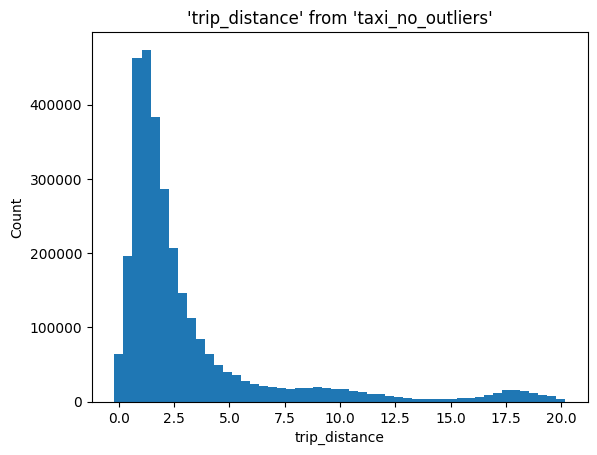

In [17]:
%sqlplot histogram --table taxi_no_outliers --column trip_distance

### Boxplot

Plotting using saved snippet : taxi_no_outliers

<Axes: title={'center': "'trip_distance' from 'taxi_no_outliers'"}, ylabel='trip_distance'>

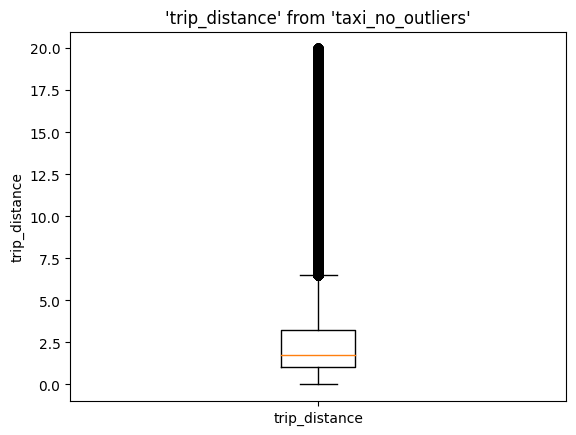

In [18]:
%sqlplot boxplot --table taxi_no_outliers --column trip_distance

### Bar

Removing NULLs, if there exists any from passenger_count

<Axes: title={'center': 'taxi'}, xlabel='passenger_count', ylabel='Count'>

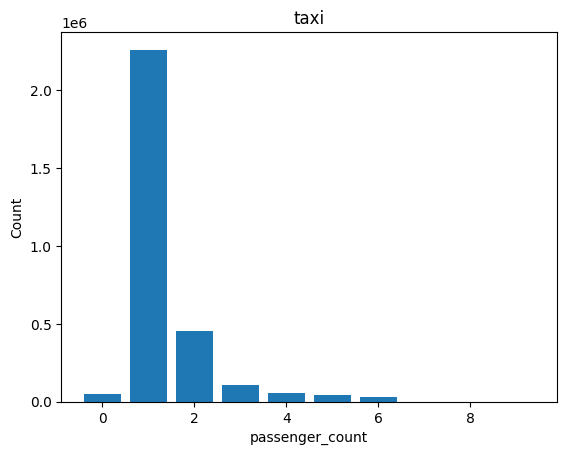

In [19]:
%sqlplot bar --table taxi --column passenger_count

## Plotting using the `ggplot` API

You can also use the `ggplot` API to create visualizations:

In [33]:
from sql.ggplot import ggplot, aes, geom_histogram

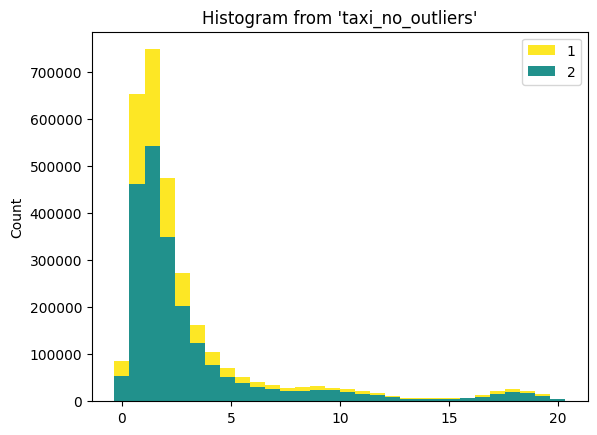

In [34]:
(
    ggplot("taxi_no_outliers", aes(x="trip_distance"), with_="taxi_no_outliers")
    + geom_histogram(bins=30, fill="vendorid")
)

## Using a native connection

Using a native connection is also supported.

In [55]:
%pip install redshift-connector --quiet

Note: you may need to restart the kernel to use updated packages.


In [56]:
import redshift_connector

conn = redshift_connector.connect(
    host=host,
    database="dev",
    port=5439,
    user=user,
    password=password,
    timeout=60,
)

In [57]:
%sql conn --alias redshift-native